In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_train = pd.read_parquet('/content/drive/MyDrive/train_dataset_hackaton2023_train.gzip')

In [ ]:
def preproces(df):

    df = df.drop('group_name', axis=1)

    # отсортируем по времени покупки
    df = df.sort_values('startdatetime')

    # Избавимся от дубликатов
    df = df.drop_duplicates()

    # СОЗДАНИЕ ФИЧЕЙ
    X = pd.DataFrame()

    X['max_bill'] = df.groupby(['customer_id', 'startdatetime']).revenue.sum().groupby('customer_id').max()
    X['min_bill'] = df.groupby(['customer_id', 'startdatetime']).revenue.sum().groupby('customer_id').min()
    X['mean_bill'] = df.groupby(['customer_id', 'startdatetime']).revenue.sum().groupby('customer_id').mean()
    X['median_bill'] = df.groupby(['customer_id', 'startdatetime']).revenue.sum().groupby('customer_id').median()
    X['mean_dish_cost'] = df.groupby('customer_id').revenue.mean()
    X['max_dish_cost'] = df.groupby('customer_id').revenue.max()
    X['min_dish_cost'] = df.groupby('customer_id').revenue.min()
    X['median_dish_cost'] = df.groupby('customer_id').revenue.median()

    X['mean_rest_size'] = df.groupby(['customer_id']).ownareaall_sqm.mean()
    X['last_rest_size'] = df.groupby(['customer_id']).ownareaall_sqm.last()

    X['time_range'] = (df.groupby('customer_id').startdatetime.last() - df.groupby('customer_id').startdatetime.first()).dt.total_seconds()
    X['mean_diff_time'] = np.array(df.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').diff().groupby('customer_id').mean().dt.total_seconds())
    X['max_diff_time'] = np.array(df.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').diff().groupby('customer_id').max().dt.total_seconds())
    X['min_diff_time'] = np.array(df.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').diff().groupby('customer_id').min().dt.total_seconds())
    X['median_diff_time'] = np.array(df.groupby(['customer_id', 'startdatetime']).startdatetime.first().groupby('customer_id').diff().groupby('customer_id').median().dt.total_seconds())


    X['counts_of_buy'] = df.groupby(['customer_id', 'startdatetime']).startdatetime.count().groupby('customer_id').count()
    X['all_revenue'] = X.counts_of_buy * X.mean_bill
    X['buy_freq'] = 1e5 * X['counts_of_buy'] / (X['time_range'] + 1)

    df['discounts'] = df['revenue'] < 3
    X['discounts'] = (df.groupby(['customer_id']).discounts).sum()


    # КАТЕГОРИАЛЬНЫЕ ФИЧИ
    mapping = pd.read_csv('mapping.csv')
    df['dish_cat'] = df['dish_name'].map(mapping.set_index('dish_name')['dish_category'])

    X['last_rest'] = np.array(df.groupby(['customer_id']).format_name.last())
    X['most_freq_dish_cat'] = df.groupby(['customer_id'])['dish_cat'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
    X['last_dish'] = df.groupby(['customer_id'])['dish_cat'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)
    X['most_freq_rest'] = df.groupby(['customer_id'])['format_name'].agg(pd.Series.mode).apply(lambda x: x[0] if type(x)==np.ndarray else x)

    cat_cols = ['last_rest', 'most_freq_dish_cat', 'last_dish', 'most_freq_rest']

    return X, cat_cols

In [ ]:
train_X, cat_cols = preproces(df_train)

In [ ]:
train_X_num = train_X.drop(cat_cols, axis=1)

Чистка датасета

In [ ]:
def drop_outliers(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   outliers_dropped = not_outliers.dropna().reset_index()

   return outliers_dropped

In [ ]:
clear_train_X_num = drop_outliers(train_X_num).set_index('customer_id')

In [ ]:
# Вытаскиваю таргет
target = df_train.groupby('customer_id').buy_post.last()

In [ ]:
clear_target = target[clear_train_X_num.index]

#Обучение

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X, target,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
model = CatBoostClassifier(iterations=150,
                        learning_rate=0.1,
                        depth=6,
                        l2_leaf_reg = 3,
                        #leaf_estimation_iterations = 10,
                        #task_type="GPU",
                        verbose=False,
                        cat_features=cat_cols)

model.fit(X_train, y_train)

In [ ]:
f1_score(y_train, model.predict(X_train))

0.8376483655932995

In [ ]:
f1_score(y_test, model.predict(X_test))

0.8376421667512345

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.733394190176829

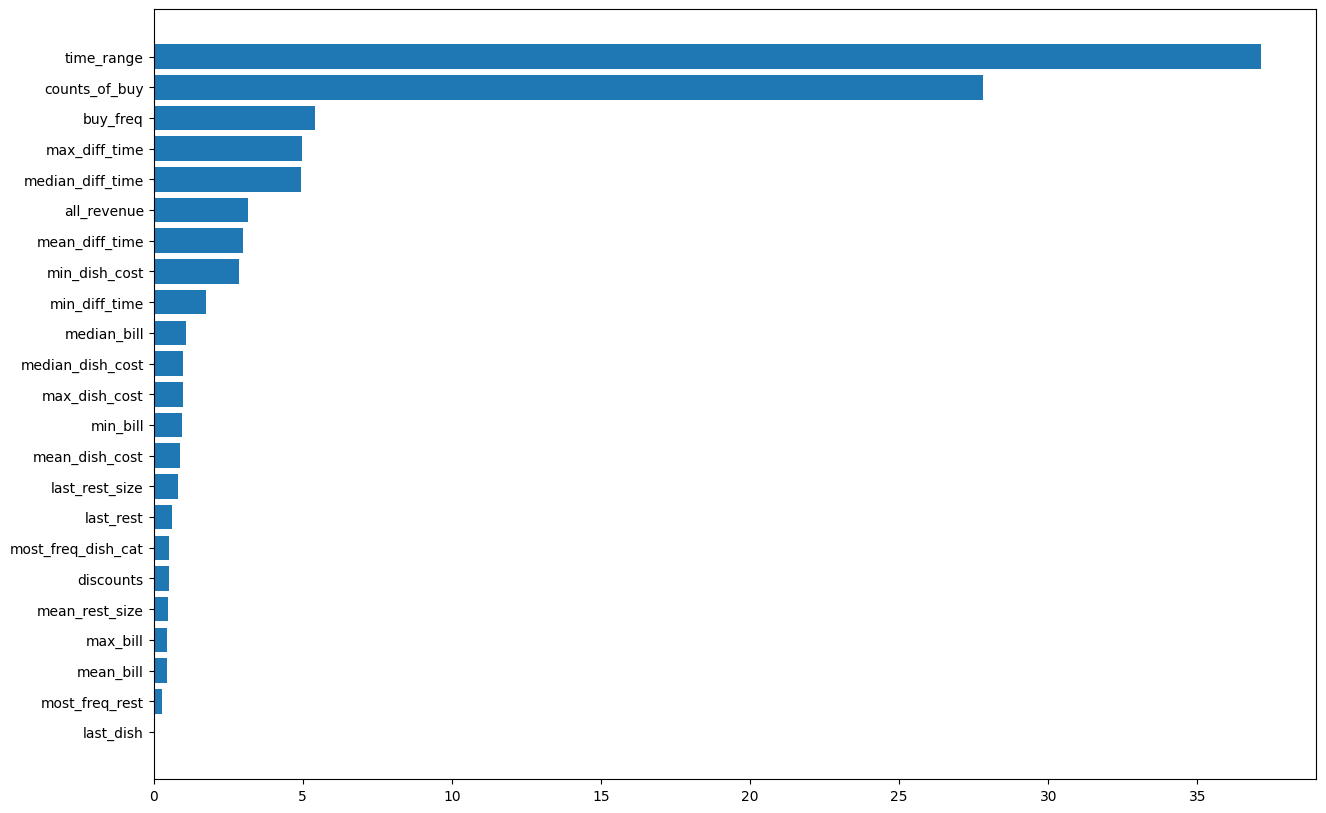

In [ ]:
importance = pd.Series(model.feature_importances_, index=train_X.columns).sort_values()

plt.figure(figsize=(15, 10))
plt.barh(importance.index, importance)
plt.show()

# Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clear_train_X_num, clear_target,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
clf = pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=42,)
                                           #class_weight={0:8,
                                           #              1:2}),
                        )
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [ ]:
f1_score(y_train, clf.predict(X_train))

0.836794547426034

In [ ]:
f1_score(y_test, clf.predict(X_test))

0.8354336162426473

In [ ]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6924462719829994

Robust scaler и GridSearch

In [ ]:
pipeline = make_pipeline(RobustScaler(),
                        LogisticRegression(random_state=42,),
                        )
parameters = {'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
             }

In [ ]:
CV_model = GridSearchCV(estimator=pipeline,
                        param_grid=parameters,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        verbose=10,)
CV_model.fit(train_X_num, target)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                   0.001]},
             scoring='f1', verbose=10)

In [ ]:
means = CV_model.cv_results_['mean_test_score']
error = CV_model.cv_results_['std_test_score']
print(means.max())

0.835437369128119


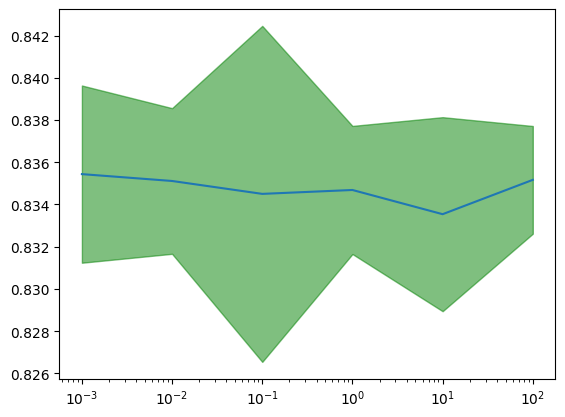

In [ ]:
grid = parameters['logisticregression__C']
plt.fill_between(grid, means - 2 * error, means + 2 * error,
                         color='green', label='filled area between errors', alpha=0.5)

plt.plot(grid, means,)
plt.xscale('log')

In [ ]:
f1_score(y_test, clf.predict(X_test))

0.8354336162426473

In [ ]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6924462719829994

#Тест

In [ ]:
df_test = pd.read_parquet('/content/drive/MyDrive/hackaton2023_test.gzip')

In [ ]:
df_test = df_test.sort_values('startdatetime')

In [ ]:
X, cat_cols = preproces(df_test)

In [ ]:
X_num = train_X.drop(cat_cols, axis=1)

In [ ]:
y = model.predict(X)

In [ ]:
customer_id = df_test.customer_id.unique()

In [ ]:
submit = pd.DataFrame({'customer_id': customer_id, 'buy_post': y})

In [ ]:
submit = submit.set_index('customer_id')
submit.to_csv('submit.csv')